## Numeryczne Rozwiązywanie Rónań Różniczkowych Cząstkowych
### Uniwersytet Jagielloński 2021
Katedra Teorii Optymalizacji i Sterowania UJ



# Metoda różnic skończonych


## Laboratorium V
### Warunek brzegowy Neumanna

$$ u_{xx}  + u_{yy} = 0$$

$$ u_{| \partial{D}} = 0 \,\,\,\,\, \text{for } x = 1 \text{ and } 0 \leq y <1$$
$$ u_{| \partial{D}} = 1 \,\,\,\,\, \text{for } y = 1 \text{ and } 0 \leq x <1$$

$$ \frac{\partial u}{\partial x} = 0 \,\,\,\,\, \text{for } x = 0 \text{ and } 0 \leq y <1$$
$$ \frac{\partial u}{\partial y} = 0 \,\,\,\,\, \text{for } y = 0 \text{ and } 0 \leq x <1$$

$$ D = \{(x, y) \in R^2 : x, y \in (0, 1) \} $$

Rozwiązanie dokładne: brak :(

In [1]:
import numpy as np
import scipy as sc
import scipy.sparse.linalg
from mpl_toolkits.mplot3d import Axes3D

import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.sparse import lil_matrix, csr_matrix
from typing import Optional
import time

In [2]:
import scipy.sparse.linalg

class SetupElliptic:
    def __init__(self, 
                 dx: float, 
                 dy: Optional[float] = None,
                 x_range = (0,1), 
                 y_range = (0,1),
                 f = lambda x, y: 0,
                 boundary_right = lambda y: 0,
                 boundary_up = lambda x: 0,
                 der_left = lambda y: 0,
                 der_down = lambda x: 0
                ):
        
        dy = dy or dx
        
        self.x_range = x_range
        self.y_range = y_range
        
        self.boundary_right = boundary_right
        self.boundary_up = boundary_up
        
        self.der_left = der_left
        self.der_down = der_down

        self.f = f
        self.x_num = round((self.x_range[1] - self.x_range[0]) / dx) + 1
        self.y_num = round((self.y_range[1] - self.y_range[0]) / dy) + 1
        self.X, self.dx = np.linspace(*self.x_range, self.x_num, retstep=True)
        self.Y, self.dy = np.linspace(*self.y_range, self.y_num, retstep=True)

In [3]:
def plot_surface(u, setup):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    X, Y = np.meshgrid(setup.X, setup.Y)
    surf = ax.plot_surface(X, Y, u, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [4]:
def scheme_elliptic(setup):
    dx = setup.dx
    dy = setup.dy
    dx2 = dx**2
    dy2 = dy**2
    nx = setup.x_num
    ny = setup.y_num
    X = setup.X
    Y = setup.Y

    # --- prepare output ---
    ret = np.zeros((nx,ny))
    ret[-1,:] = np.array([setup.boundary_right(Y[j]) for j in range(ny)])
    ret[:,-1] = np.array([setup.boundary_up(X[i]) for i in range(nx)])
    
    
    # --- prepare rhs ---
    # neumann condition
    n = np.zeros((nx-1, ny-1))
    n[-1,:] = (-1/dx2)*ret[-1,:-1]
    n[:,-1] = (-1/dy2)*ret[:-1,-1]
    
    # dirichlet condition
    d = np.zeros((nx-1,ny-1))
    d[0,:] = (2/dx)*np.array([setup.der_left(Y[j]) for j in range(ny-1)])
    d[:,0] = (2/dy)*np.array([setup.der_down(X[i]) for i in range(nx-1)])
    
    # f
    f = np.array([[setup.f(X[i], Y[j]) for j in range(0,ny-1)] for i in range(0,nx-1)])
    
    # reshape to 1d
    rhs = (f + d + n).reshape((nx-1)*(ny-1), order='C')
    
    
    # --- prepare matrix ---
    ones = np.ones((nx-1)*(ny-1))
    Ly = scipy.sparse.spdiags([ones, -2*ones, ones], [-1,0,1], ny-1, ny-1, format="csr")
    Ly[0,1] = 2
    My = (1/dy ** 2) * scipy.sparse.block_diag([Ly]*(nx-1))
    I = np.identity(ny-1)
    Mx_data = [ [None]*(nx-1) for i in range(nx-1)]
    Mx_data[0][0] = -2*I
    Mx_data[1][0] = I
    Mx_data[0][1] = 2*I
    Mx_data[1][1] = -2*I
    for i in range(2, nx-1):
        Mx_data[i][i] = -2*I
        Mx_data[i-1][i] = I
        Mx_data[i][i-1] = I
    Mx = (1/dx ** 2) * scipy.sparse.bmat(Mx_data)
    M = Mx + My
    
    
    # --- solve + update output ---
    ret[:-1,:-1] = scipy.sparse.linalg.spsolve(M, rhs).reshape(setup.x_num-1, setup.y_num-1)
    return ret.T

In [5]:
%%time
# numerical solution
setup_elliptic = SetupElliptic(
    dx=0.01, 
    dy=0.01,
    x_range=(0.0, 1.0),
    y_range=(0.0, 1.0),
    f=lambda x,y: 0,
    boundary_right = lambda y: 0, # u(1,y)
    boundary_up = lambda x: 1,    # u(x,1)
    der_left = lambda y: 0,       # du/dx(0,y)
    der_down = lambda x: 0        # du/dy(x,0)
)

numerical_elliptic = scheme_elliptic(setup_elliptic)

CPU times: user 89.7 ms, sys: 22.1 ms, total: 112 ms
Wall time: 103 ms


<IPython.core.display.Javascript object>


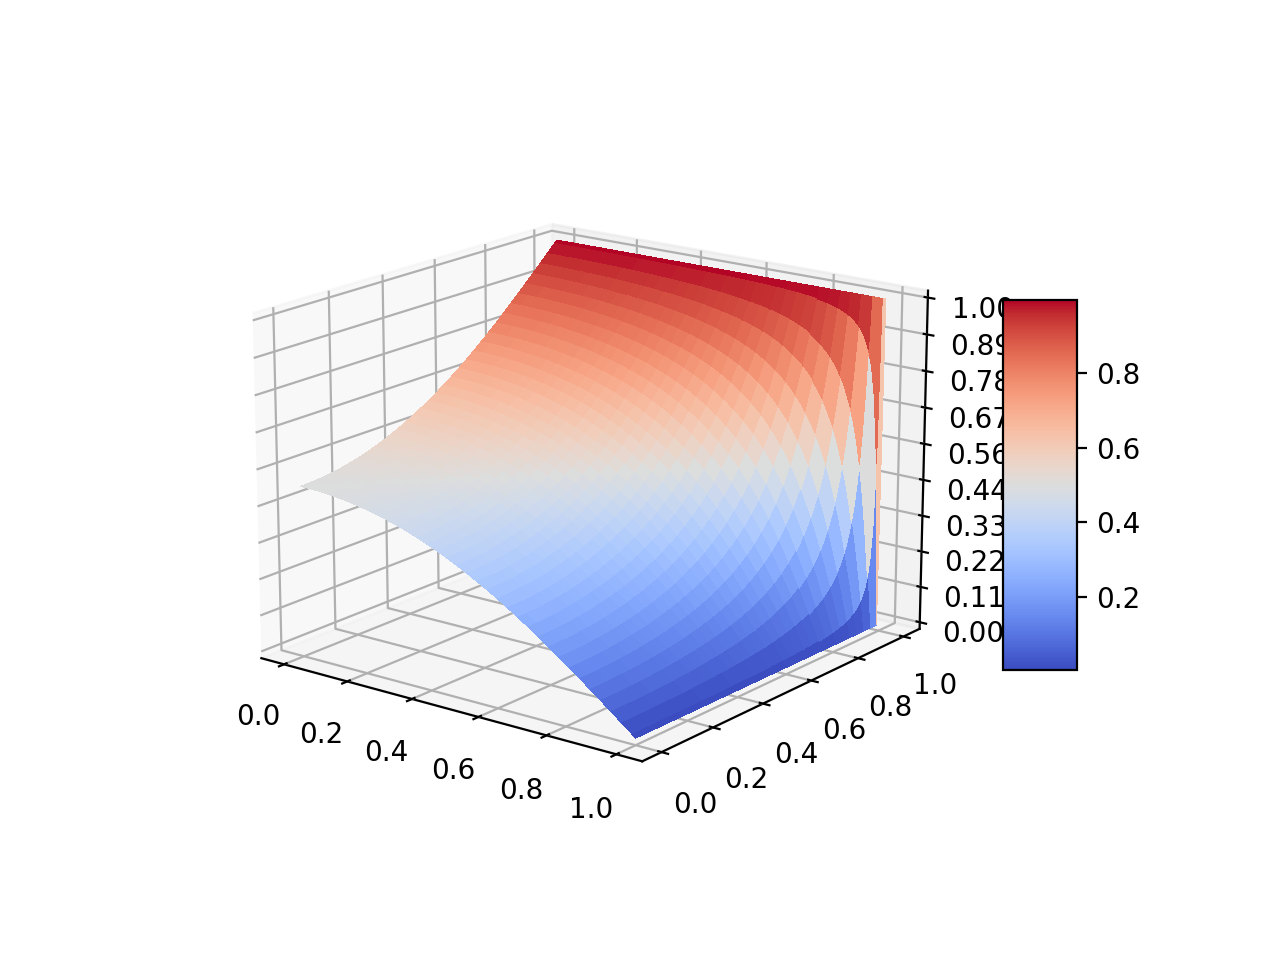

In [6]:
plot_surface(numerical_elliptic, setup_elliptic)

# Rozważyć warunki brzegowe (Dirichleta i Neumanna) różne od zera



<IPython.core.display.Javascript object>


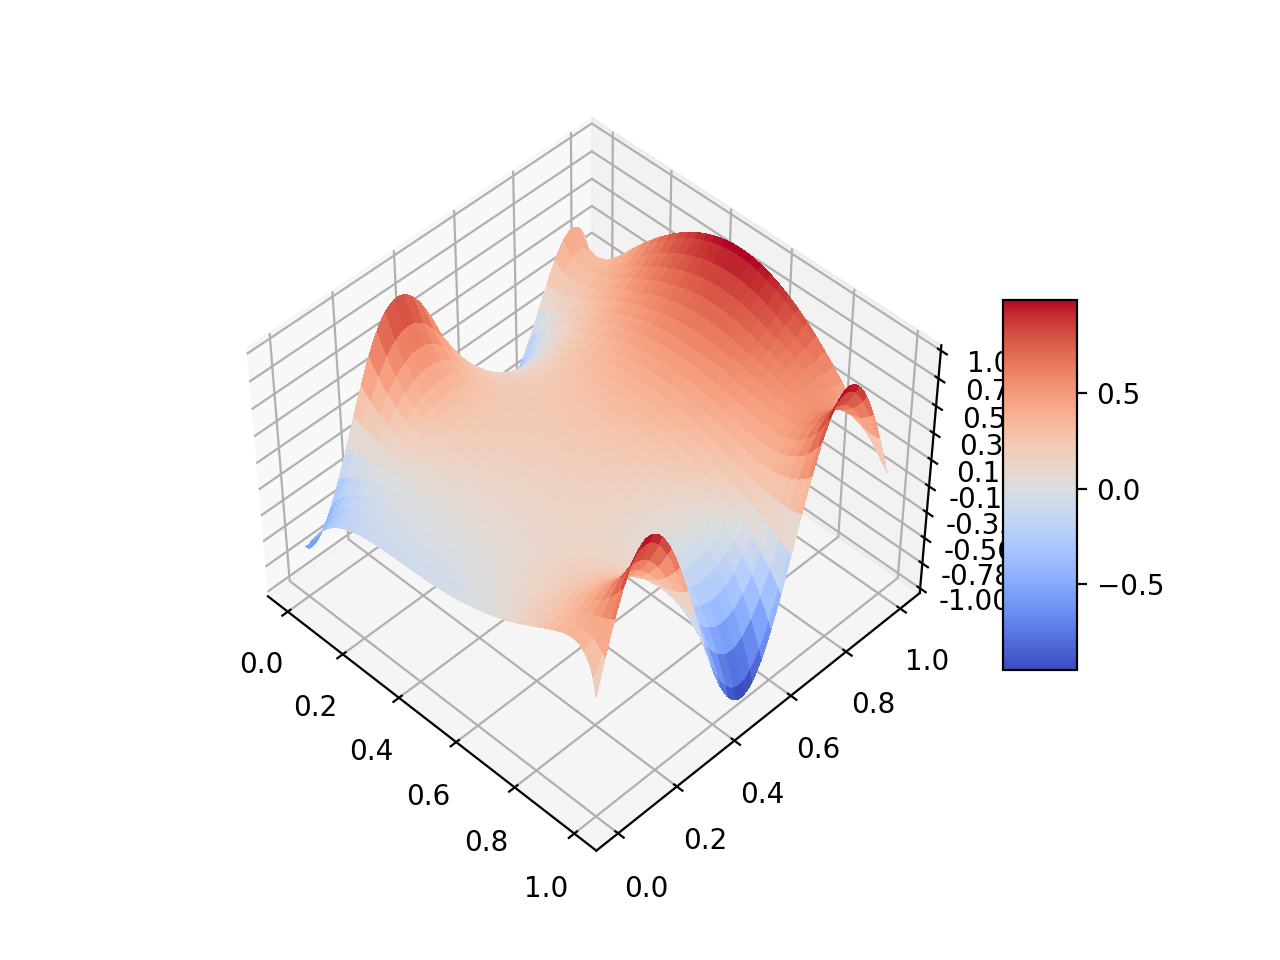

CPU times: user 194 ms, sys: 24.4 ms, total: 219 ms
Wall time: 139 ms


In [7]:
%%time
# numerical solution
setup_elliptic = SetupElliptic(
    dx=0.01, 
    dy=0.01,
    x_range=(0.0, 1.0),
    y_range=(0.0, 1.0),
    f=lambda x,y: 0,
    boundary_right = lambda y: np.sin(3*np.pi*y), # u(1,y)
    boundary_up = lambda x: np.sin(np.pi*x),    # u(x,1)
    der_left = lambda y:  7*np.cos(3*np.pi*y),      # du/dx(0,y)
    der_down = lambda x: np.sin(np.pi*x)        # du/dy(x,0)
)

numerical_elliptic = scheme_elliptic(setup_elliptic)
plot_surface(numerical_elliptic, setup_elliptic)